In [1]:
import torch
import json
import os
import sys
import types
from argparse import Namespace

### FILL THESE VALUES ###

PATH_TO_REPO         = os.path.expanduser('~/Documents/uzh_tum/models/utae-paps') # '/home/eco03/github/utae-paps/'
PATH_TO_DATA         = os.path.expanduser('~/Data/SEN12MSCRTS_val_test')

experiment_name      = 'utae_S1S2_t5_L1SSIM_all'
PATH_TO_UTAE_WEIGHTS = os.path.join(os.path.expanduser('~/Documents/uzh_tum/models/utae-paps/results'), experiment_name) # '/home/eco03/DATA/UTAE_zenodo/'
device               = 'cuda' # or "cpu"

#######

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Colormap, TwoSlopeNorm, ListedColormap
matplotlib.rcParams.update({'font.size': 15})

from matplotlib import patches
import numpy as np

import scipy.stats

sys.path.append(PATH_TO_REPO) 
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from src.backbones.utae import UTAE
from src.panoptic.paps import PaPs
from src.utils import pad_collate
from src.model_utils import get_model
from data.dataLoader import SEN12MSCRTS

from captum.attr import IntegratedGradients
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import cv2 as cv

import warnings
warnings.filterwarnings('ignore')

# colormap (same as in the paper)
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=20)


from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
redgreen = LinearSegmentedColormap.from_list("shap", colors)

/home/eco04/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Detected 11 keypoints.


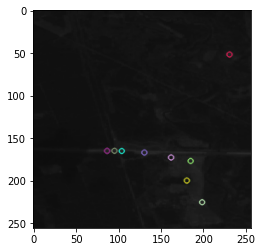

In [2]:
img = cv.imread(os.path.expanduser('~/Documents/uzh_tum/models/utae-paps/results/utae_SSIM/plots/epoch_185/train/img-2_target_t-0.png'))
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
# initiate a SIFT instance, see https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html
sift = cv.SIFT_create(nfeatures=10, contrastThreshold=0.01,edgeThreshold=10) # only keep top-10 keypoints, sorted by local contrast score 
kp = sift.detect(gray,None) # TODO: You can pass a mask if you want to search only a part of the image.
print(f'Detected {len(kp)} keypoints.')
img=cv.drawKeypoints(gray,kp,img)
cv.imwrite(os.path.expanduser('~/Documents/sift_keypoints.jpg'),img)
imgplot = plt.imshow(img)
plt.show()

In [3]:
def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    elif isinstance(x, dict):
        return {k: recursive_todevice(v, device) for k, v in x.items()}
    else:
        return [recursive_todevice(c, device) for c in x]

def prepare_data(batch, device, config):
    in_S2 = recursive_todevice(batch['input']['S2'], device)
    in_S2_td = recursive_todevice(batch['input']['S2 TD'], device)
    if config.batch_size>1: in_S2_td = torch.stack((in_S2_td)).T
    in_m  = torch.stack(recursive_todevice(batch['input']['masks'], device)).swapaxes(0,1)
    target_S2 = recursive_todevice(batch['target']['S2'], device)
    y     = torch.cat(target_S2,dim=0).unsqueeze(1)

    if config.use_sar: 
        in_S1 = recursive_todevice(batch['input']['S1'], device)
        in_S1_td = recursive_todevice(batch['input']['S1 TD'], device)
        if config.batch_size>1: in_S1_td = torch.stack((in_S1_td)).T
        x     = torch.cat((torch.stack(in_S1,dim=1), torch.stack(in_S2,dim=1)),dim=2)
        dates = torch.stack((torch.tensor(in_S1_td),torch.tensor(in_S2_td))).float().mean(dim=0).to(device)
    else:
        x     = torch.stack(in_S2,dim=1)
        dates = torch.tensor(in_S2_td).float().to(device)

    if config.input_size < 256: # batch sub-samples if mosaicing patches
        x_mosaic = x.unfold(4, config.input_size, config.input_size).unfold(3, config.input_size, config.input_size)
        x_batch  = x_mosaic.reshape(-1, config.input_t, x.shape[2], config.input_size, config.input_size).swapaxes(-1,-2)
        y_mosaic = y.unfold(4, config.input_size, config.input_size).unfold(3, config.input_size, config.input_size)
        y_batch  = y_mosaic.reshape(-1, 1, y.shape[2], config.input_size, config.input_size).swapaxes(-1,-2)
        m_mosaic = in_m.unfold(3, config.input_size, config.input_size).unfold(2, config.input_size, config.input_size)
        m_batch  = m_mosaic.reshape(-1, config.input_t, config.input_size, config.input_size).swapaxes(-1,-2)

        x, y, in_m, dates = x_batch, y_batch, m_batch, dates.expand(x_batch.shape[0],-1)
    return x, y, in_m, dates

In [4]:
def load_model(path, device, fold=0, mode='reconstruct', add_args=None):
    """Load pre-trained model"""
    with open(os.path.join(path, 'conf.json')) as file:
        config = json.loads(file.read())
        
    if add_args is not None:
        config = {**config, **add_args}
    config = Namespace(**config)
    model = get_model(config, mode = mode).to(device)

    sd = torch.load(
        #os.path.join(path, "Fold_{}".format(fold+1), "model.pth.tar"),
        os.path.join(path, "model.pth.tar"),
        map_location=device
        )
    model.load_state_dict(sd['state_dict'])
    
    
    return model

def get_rgb(x,b=0,t_show=6):
    """Gets an observation from a time series and normalises it for visualisation."""
    rgb_bands = [5,4,3] if x.shape[2]==15 else [3,2,1]
    im = x[b,t_show, rgb_bands].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    # normalize dynamic range of im
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [5]:
# Load dataset and models

fold = 0
batch_size = 5
root1 = '/media/DATA/SEN12MSCRTS'
root2 = '~/Data/SEN12MSCRTS_val_test'
region = "all"
sample_type = "cloudy_cloudfree"
input_t = 5
use_sar = True
patch_size = 256
min_cov, max_cov = 0.25, 1.0

dt_test     = SEN12MSCRTS(os.path.expanduser(root2), split='test', region=region, sample_type=sample_type , 
                          n_input_samples=input_t, import_data_path=None, min_cov=min_cov, max_cov=max_cov)

dl = torch.utils.data.DataLoader(
    dt_test,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=num_workers,
)

iterator =  dl.__iter__()
device   = torch.device(device)


utae = load_model(PATH_TO_UTAE_WEIGHTS, device=device, fold=fold, mode='reconstruct', add_args=dict(positional_encoding=False)).eval()


Processing paths for test split of region all


100%|█████| 17/17 [00:01<00:00, 13.97it/s]


In [6]:
# fetch next batch of data

batch  = iterator.__next__()
config = types.SimpleNamespace()
for adx, attr in enumerate(['batch_size', 'use_sar', 'input_size']):
    setattr(config, attr, [batch_size, use_sar, patch_size][adx])
x, y, in_m, dates = prepare_data(batch, device, config)

In [7]:
n      = 1           # batch sample n in [0, ..., B] to analyze
target = y           # shapes are [B,T,C,H,W], would be [B,H,W] #y[:,:,:,-1] # TODO
t      = input_t     # input time points to consider, with t in [0, ..., T]
h, w   = 64, 64      # window size to attribute relevancy to

# default position of px to be explained
px_i, px_j = 20, 30 # top_kp_y, top_kp_x

# print paths to target images
print(batch['target']['S1_path'][0][n])
print(batch['target']['S2_path'][0][n])

/home/eco04/Data/SEN12MSCRTS_val_test/ROIs1158/106/S1/14/s1_ROIs1158_106_ImgNo_14_2018-06-09_patch_1.tif
/home/eco04/Data/SEN12MSCRTS_val_test/ROIs1158/106/S2/14/s2_ROIs1158_106_ImgNo_14_2018-06-08_patch_1.tif


Detected 10 keypoints. Top keypoint at (207.3450927734375, 44.17241287231445)
Window is in [12:76,175:239], of size [64,64]
Updated window is in [12:76,175:239], of size [64,64]


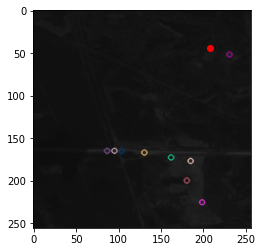

In [8]:
# process target

def get_kps(img):
    # process image
    img = get_rgb(img, b=n, t_show=0)[:,:,::-1] 
    img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY).astype('uint8')

    # initiate a SIFT instance, see https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html
    sift = cv.SIFT_create(nfeatures=10, contrastThreshold=0.01, edgeThreshold=10) # only keep top-10 keypoints, sorted by local contrast score 

    kp = sift.detect(gray,None) # TODO: You can pass a mask if you want to search only a part of the image.
    top_kp_x, top_kp_y = kp[0].pt

    # define a window around the given keypoint
    height, width = img.shape[:2]
    # get edges of the window frame
    left, right = max(0, np.int(top_kp_x)-w//2), min(width, np.int(top_kp_x)+w//2)
    top, bot    = max(0, np.int(top_kp_y)-h//2), min(height,np.int(top_kp_y)+h//2)

    win_height, win_width = bot-top, right-left
    print(f'Detected {len(kp)} keypoints. Top keypoint at {(top_kp_x, top_kp_y)}')
    print(f'Window is in [{top}:{bot},{left}:{right}], of size [{win_height},{win_width}]')

    # TODO: in its current implementation, shifting the window also moves the center away from keypoint!
    # move window so it fits into the image while keeping its size
    if win_height < h:
        if top == 0: bot += h - (win_height) # move bottom down
        elif bottom == height: top -= h - (win_height) # move top up
    if win_width < w:
        if left == 0: right += w - (win_width) # move right rightwards
        elif right == width: left -= w - (win_width) # move left leftwards
    return top_kp_x, top_kp_y, top, bot, left, right
        
# get keypoint and window
top_kp_x, top_kp_y, top, bot, left, right = get_kps(y)
win_height, win_width = bot-top, right-left
print(f'Updated window is in [{top}:{bot},{left}:{right}], of size [{win_height},{win_width}]')

img=cv.drawKeypoints(gray,kp,img)
cv.imwrite(os.path.expanduser('~/Documents/sift_keypoints.jpg'),img)
imgplot = plt.imshow(img)
plt.scatter(top_kp_x, top_kp_y,marker='o',color='r')
plt.show()

In [9]:
# instantiate integrated gradients object,
# see: https://captum.ai/docs/extension/integrated_gradients
#wrapper_kth_dim = lambda utae()
ig = IntegratedGradients(utae.eval())

## Baseline: 
#B,T,C,H,W = x.shape
#baselines = dt.norm['S2'][0].unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
#baselines = baselines.repeat((B,T,1,H,W))
baselines = torch.zeros(x.shape,device=device)

print(x[[n],:t,:,top:bot, left:right].shape)
print(baselines[[n],:t,:,top:bot, left:right].shape)
print(px_i, px_j)
print(dates[[n],:t])

torch.cuda.empty_cache()
# perform regression-task attribution, see
# https://github.com/pytorch/captum/issues/206
# https://github.com/pytorch/captum/blob/4faf1ea49fbff90af92b759c1f763dda1d8be705/captum/attr/_core/integrated_gradients.py#L80 
# TODO: multivariate outputs raise error: https://github.com/pytorch/captum/blob/afc4759083b29ace64c5a80481ad5306ad41eab4/captum/_utils/gradient.py#L113

# 1) get attention weights to compare against
with torch.no_grad():
    pred , attention = utae(x[[n],:t,...], batch_positions=dates[[n],:t], return_att=True)

# 2) get relevancy attributions
bands = 13
mean_band_attr = torch.zeros((bands, *x[[n],:t,:,top:bot, left:right].shape))
mean_err       = torch.zeros((bands))

for band in range(bands):
    # get attribution tensors, are of same shape as windowed input tensor
    attributions, approximation_error = ig.attribute(inputs=x[[n],:t,:,top:bot, left:right], 
                                                     baselines=baselines[[n],:t,:,top:bot, left:right], 
                                                     target=(0, band, int(bot-top)//2, int(right-left)//2),#(0, band, int(top_kp_y), int(top_kp_x)),
                                                     additional_forward_args=dates[[n],:t],
                                                     return_convergence_delta=True,
                                                     n_steps=50)
    mean_band_attr[band] = attributions
    mean_err[band]       = approximation_error
mean_band_attr = mean_band_attr.mean(axis=0)
mean_err = mean_err.mean(axis=0)


# compute & collect stats
# windowed attribution tensor, integrated across bands, is [T x h x w]
at_all = mean_band_attr[0, ...].mean(dim=1).cpu()
at_s1  = mean_band_attr[0, :, [0,1], ...].mean(dim=1).cpu()
at_s2  = mean_band_attr[0, :, 2:, ...].mean(dim=1).cpu()

# put windowed tensor into full image
at_full_all = torch.zeros((t, *x.shape[-2:])).cpu()
at_full_all[:,top:bot, left:right] = at_all
at_full_s1 = torch.zeros((t, *x.shape[-2:])).cpu()
at_full_s1[:,top:bot, left:right] = at_s1
at_full_s2 = torch.zeros((t, *x.shape[-2:])).cpu()
at_full_s2[:,top:bot, left:right] = at_s2
at_max_all = at_all.max()                          # max spatial attribution in H x W space
at_min_all = at_all.min()                          # min spatial attribution in H x W space
at_max_s1 = at_s1.max()                            # max spatial attribution in H x W space
at_min_s1 = at_s1.min()                            # min spatial attribution in H x W space
at_max_s2 = at_s2.max()                            # max spatial attribution in H x W space
at_min_s2 = at_s2.min()                            # min spatial attribution in H x W space

cum_attention = attention[:,0,:, int(top_kp_y)//8, int(top_kp_x)//8].sum(0) # currently integrating across heads

integr_masks  = in_m.float().mean(axis=1).cpu()

torch.Size([1, 5, 15, 64, 64])
torch.Size([1, 5, 15, 64, 64])
20 30
tensor([[1372.0000, 1450.0000, 1534.5000, 1559.0000, 1654.5000]],
       device='cuda:0')


In [10]:
print(x.shape)
print(pred.shape)
print(y.shape)
print(attributions.shape)
print(mean_band_attr.shape)
print(attributions.shape)
print((0, band, int(bot-top)//2, int(right-left)//2))

torch.Size([5, 5, 15, 256, 256])
torch.Size([1, 1, 13, 256, 256])
torch.Size([5, 1, 13, 256, 256])
torch.Size([1, 5, 15, 64, 64])
torch.Size([1, 5, 15, 64, 64])
torch.Size([1, 5, 15, 64, 64])
(0, 12, 32, 32)


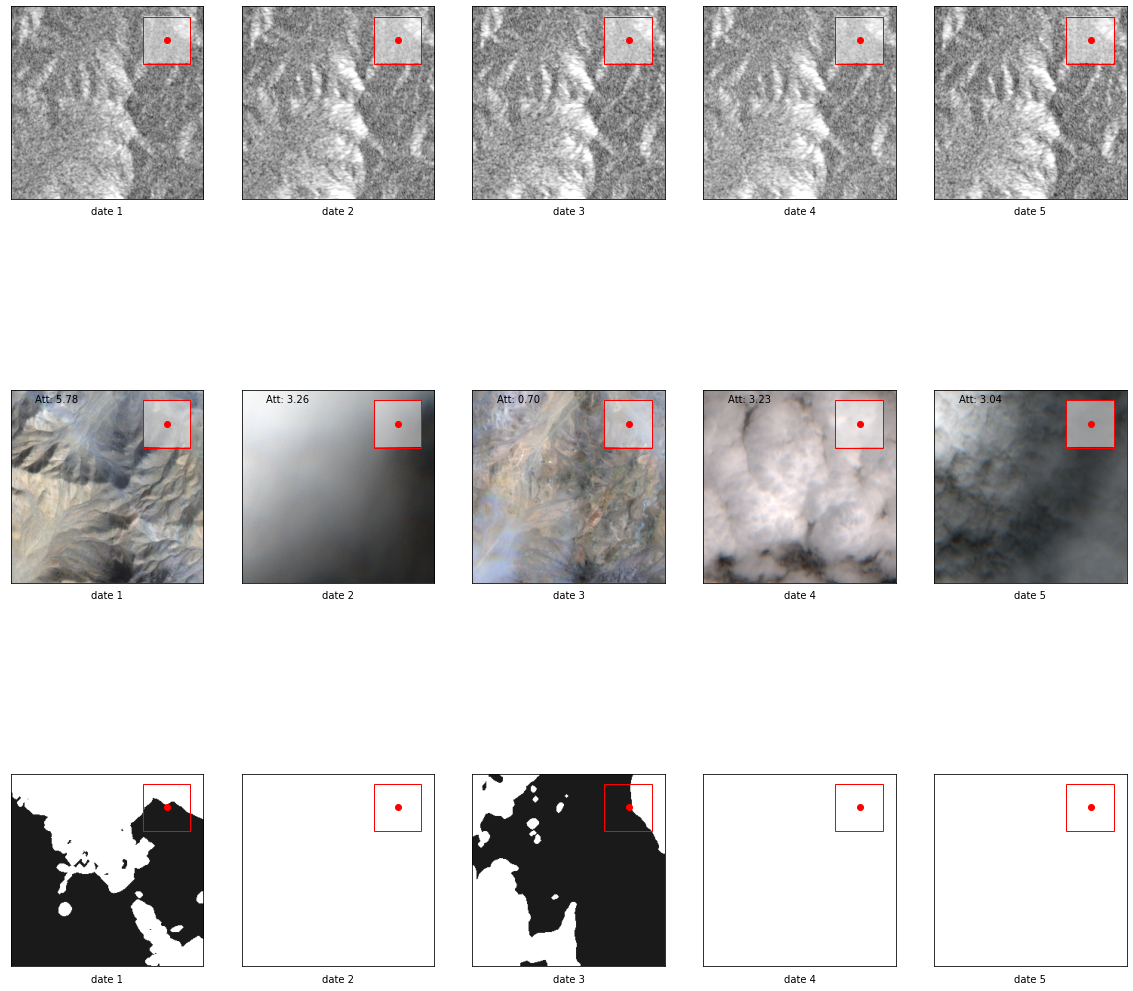

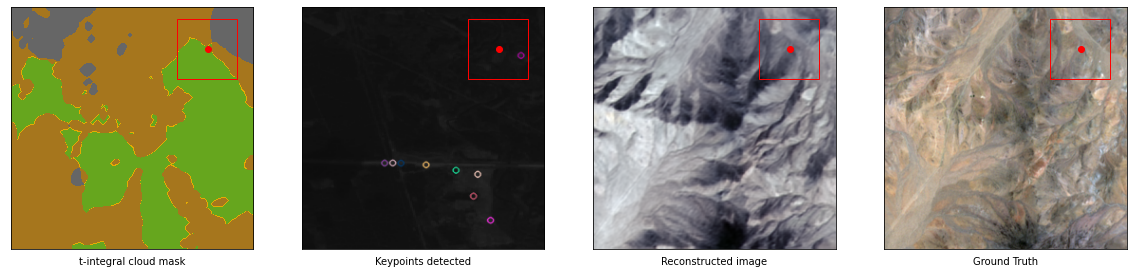

In [11]:
# plot the whole inputs, also beyond the explained window
fig, axes = plt.subplots(3, t, figsize=(20,20))

for i in range(t): # plot each input time point
    sar_plot=x[n, i, 0].cpu().numpy()
    axes[0,i].imshow(sar_plot[:,:], alpha=0.9, cmap='gray')
    axes[1,i].imshow(get_rgb(x, b=n, t_show=i)[:,:], alpha=0.9)
    mask_plot=in_m[n, i, ...].cpu().numpy()
    axes[2,i].imshow(mask_plot[:,:], alpha=0.9, cmap='gray', vmin=0.0, vmax=1.0)
    
    for row in range(3):
        # superimpose attribution maps
        if row <2: 
            norm = TwoSlopeNorm(vmin=at_min_all, vcenter=0, vmax=at_max_all)
            axes[row,i].scatter(top_kp_x, top_kp_y,marker='o',color='r')
        if row==0:
            t_plot = at_full_s1[i]
            t_plot[t_plot==0] = np.nan
            axes[row,i].imshow(t_plot, cmap='bwr', alpha=.5, norm=norm)
        if row==1:
            t_plot = at_full_s2[i]
            t_plot[t_plot==0] = np.nan
            axes[row,i].imshow(t_plot, cmap='bwr', alpha=.5, norm=norm)
        if row >=2:
            axes[row,i].scatter(top_kp_x, top_kp_y,marker='o',color='r')
        # annotate plots
        axes[row,i].set_xlabel(f'date {i+1}')
        axes[row,i].set_xticks([])
        axes[row,i].set_yticks([])
        rect = patches.Rectangle((left,bot), w-1, -(h-1), linewidth=1, edgecolor='r', facecolor='none')
        axes[row,i].add_patch(rect)
    axes[1,i].text(32,16, 'Att: {:.2f}'.format(cum_attention[i]))
    

# plot prediction, gt and keypoints
fig, axes = plt.subplots(1, 4, figsize=(20,20))
axes = axes.ravel() # collapse into 1D

axes[-1].imshow(get_rgb(y, b=n, t_show=0)[:,:], alpha=1.0)
axes[-2].imshow(get_rgb(pred, b=0, t_show=0)[:,:], alpha=1.0)
axes[-3].imshow(img[:,:], alpha=1.0)
t_mask = axes[-4].imshow(integr_masks[n], cmap='Dark2', alpha=1.0, vmin=0.0, vmax=1.0)
#fig.colorbar(t_mask, ticks=list(np.linspace(0.0, 1.0, num=t)), orientation="horizontal", location="bottom",ax=axes[-4])
axes[-1].set_xlabel('Ground Truth')
axes[-2].set_xlabel('Reconstructed image')
axes[-3].set_xlabel('Keypoints detected')
axes[-4].set_xlabel('t-integral cloud mask')
for axe in axes:
    axe.scatter(top_kp_x, top_kp_y,marker='o',color='r')
    axe.set_xticks([])
    axe.set_yticks([])
    rect = patches.Rectangle((left,bot), w-1, -(h-1), linewidth=1, edgecolor='r', facecolor='none')
    axe.add_patch(rect)

Text(0.5, 0, 't-integral cloud mask')

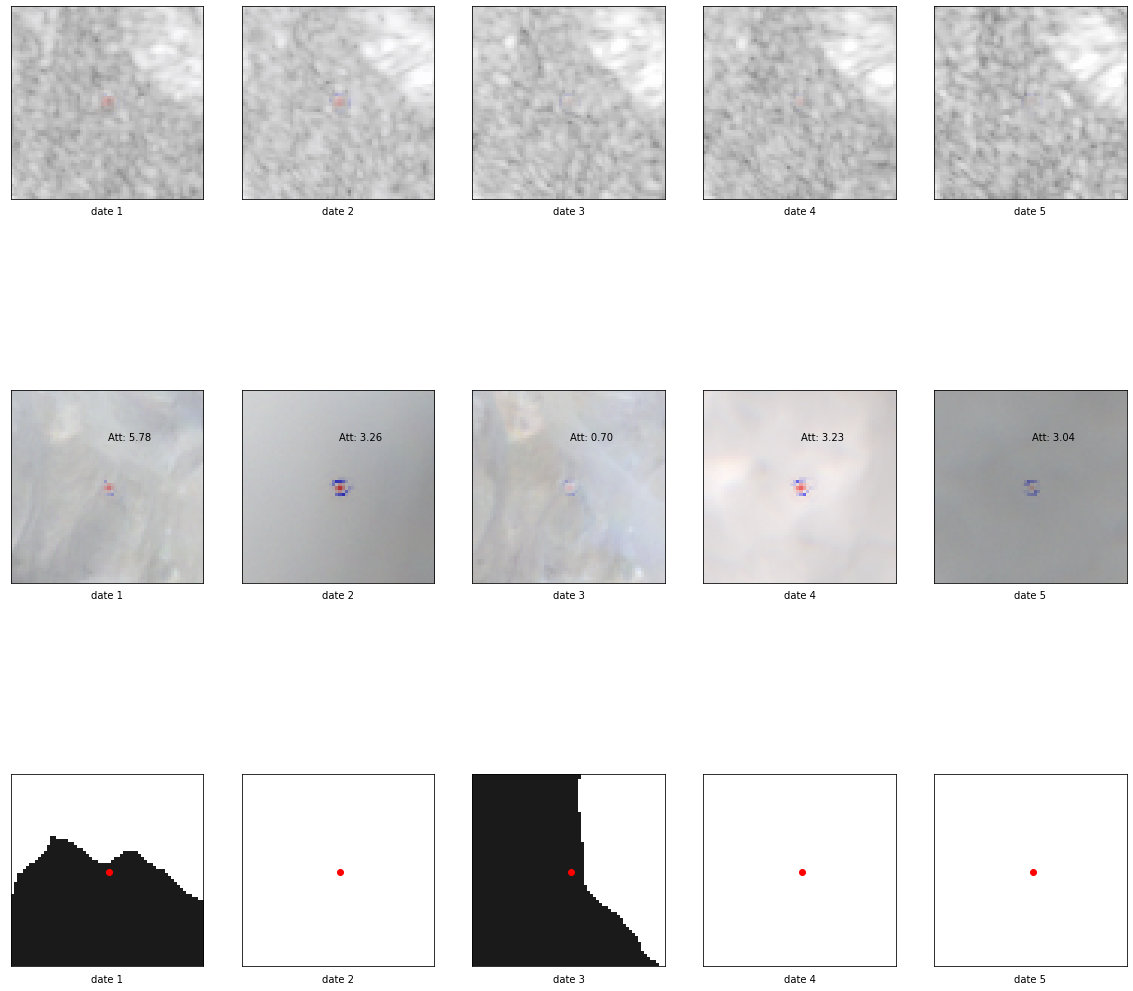

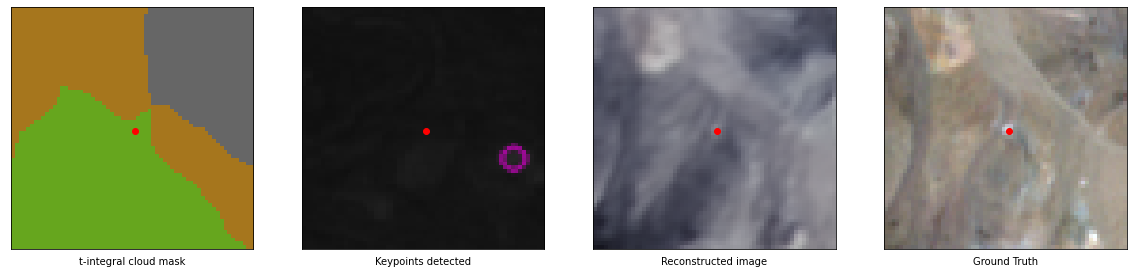

In [12]:
# plot only the explained window
fig, axes = plt.subplots(3, t, figsize=(20,20))

for i in range(t): # plot each input time point
    sar_plot=x[n, i, 0].cpu().numpy()
    axes[0,i].imshow(sar_plot[top:bot, left:right], alpha=0.9, cmap='gray')
    axes[1,i].imshow(get_rgb(x, b=n, t_show=i)[top:bot, left:right], alpha=0.9)
    mask_plot=in_m[n, i, ...].cpu().numpy()
    axes[2,i].imshow(mask_plot[top:bot, left:right], alpha=0.9, cmap='gray', vmin=0.0, vmax=1.0)
    
    for row in range(3):
        # superimpose attribution maps
        if row <2: 
            norm = TwoSlopeNorm(vmin=at_min_all, vcenter=0, vmax=at_max_all)
            #axes[row,i].imshow(t_plot[top:bot, left:right], cmap='bwr', alpha=.5, norm=norm)
        if row==0:
            t_plot = at_full_s1[i]
            t_plot[t_plot==0] = np.nan
            axes[row,i].imshow(t_plot[top:bot, left:right], cmap='bwr', alpha=.5, norm=norm)
        if row==1:
            t_plot = at_full_s2[i]
            t_plot[t_plot==0] = np.nan
            axes[row,i].imshow(t_plot[top:bot, left:right], cmap='bwr', alpha=.5, norm=norm)
        if row >=2:
            axes[row,i].scatter(top_kp_x-left, top_kp_y-top,marker='o',color='r')
        # annotate plots
        axes[row,i].set_xlabel(f'date {i+1}')
        axes[row,i].set_xticks([])
        axes[row,i].set_yticks([])
    axes[1,i].text(32,16, 'Att: {:.2f}'.format(cum_attention[i]))
    

# plot prediction, gt and keypoints
fig, axes = plt.subplots(1, 4, figsize=(20,20))
axes = axes.ravel() # collapse into 1D

axes[-1].imshow(get_rgb(y, b=n, t_show=0)[top:bot, left:right], alpha=1.0)
axes[-2].imshow(get_rgb(pred, b=0, t_show=0)[top:bot, left:right], alpha=1.0)
axes[-3].imshow(img[top:bot, left:right], alpha=1.0)
t_mask = axes[-4].imshow(integr_masks[n][top:bot, left:right], cmap='Dark2', alpha=1.0, vmin=0.0, vmax=1.0)
#fig.colorbar(t_mask, ticks=list(np.linspace(0.0, 1.0, num=t)), orientation="horizontal", location="bottom",ax=axes[-4])
for axe in axes:
    axe.scatter(top_kp_x-left, top_kp_y-top,marker='o',color='r')
    axe.set_xticks([])
    axe.set_yticks([])
axes[-1].set_xlabel('Ground Truth')
axes[-2].set_xlabel('Reconstructed image')
axes[-3].set_xlabel('Keypoints detected')
axes[-4].set_xlabel('t-integral cloud mask')

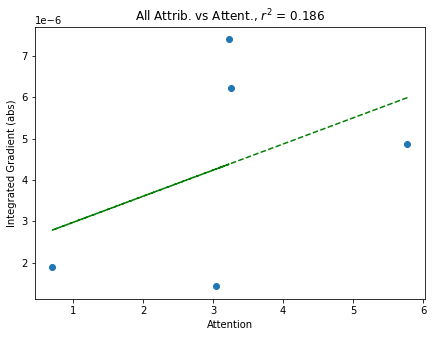

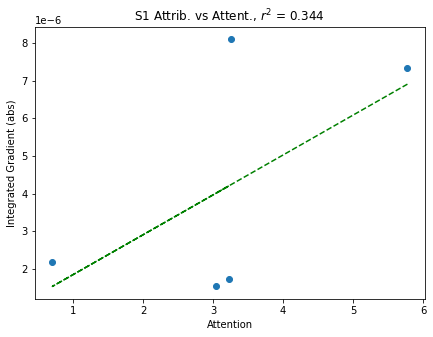

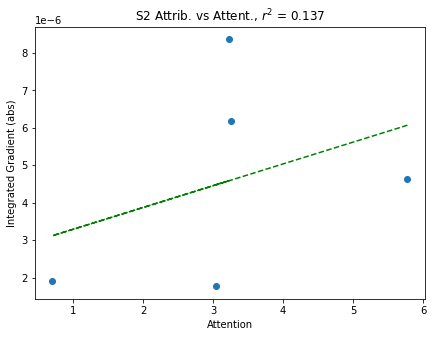

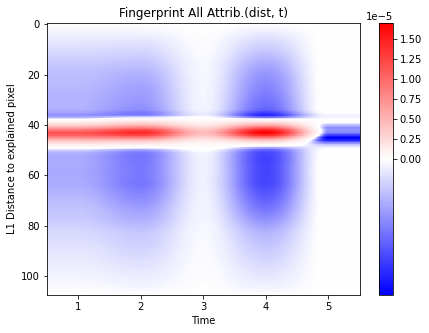

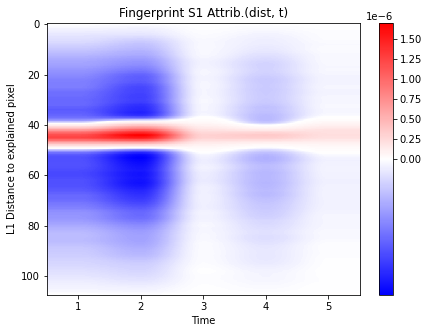

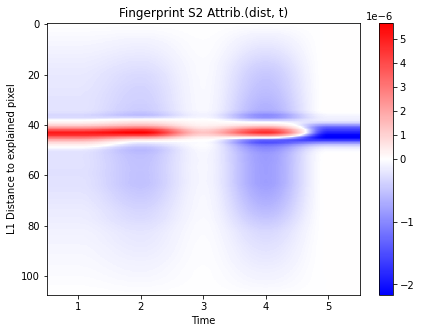

'\nfig, axes = plt.subplots(3,1, figsize=(10,13))\nplt.subplots_adjust(hspace=0.4)\n\n#date_form = DateFormatter("%b-%d")\n#axes[0].xaxis.set_major_formatter(date_form)\n\naxes[0].plot(exp_dates,out.sum((1,2)))\nax2 = axes[0].twinx()\nax2.plot(exp_dates, ca, color=\'orange\')\nax2.set_ylim(bottom=axes[0].get_ylim()[0])\naxes[0].legend([\'Cum. IG\'])\nax2.legend([\'Attention\'], loc=(0.008,.7))\naxes[0].set_title(\'Date Importance\')\n\naxes[1].plot([10*i for i in range(out.shape[-1])], out.sum((0,1)))\naxes[1].set_title(\'Spatial Importance\')\naxes[1].set_xlabel(\'distance to explained pixel (m)\')\n\n\naxes[2].bar(range(1, out.shape[1]+1), out.sum((0,2)))\naxes[2].set_xticks(range(1, out.shape[1]+1), bands)\naxes[2].set_title(\'Channel Importance\')\nplt.show()\n'

In [13]:
# correlate (IG) attribution scores vs. (U-TAE) attention mask scores

def corr_attri_attent(attri, mod):
    fig, ax = plt.subplots(figsize=(7,5))
    ca = cum_attention.cpu().numpy()
    exp = attri.abs().sum((1,2)).cpu().numpy()
    # scatter plot arguments are x, y, ...
    ax.scatter(ca, attri.abs().sum((1,2)).cpu())
    ax.set_xlabel('Attention')
    ax.set_ylabel('Integrated Gradient (abs)')

    lr = LinearRegression()
    lr.fit(ca.reshape(-1, 1), exp.reshape(-1, 1))
    line = (lr.intercept_ + lr.coef_ * ca).reshape(-1)
    r2 = r2_score(exp.reshape(-1, 1),line)

    ax.plot(ca, line, color='g', linestyle='--')
    ax.set_title(f'{mod} Attrib. vs Attent., $r^2$ = {"%.3f" % r2}')

    plt.show()
    
def fingerprint_attri(mod):
    # analyze (IG) attribution scores as a function of time & pixel distance to interest point
    B,T,C,H,W = attributions.shape

    distance_mask = np.zeros((H,W), dtype=int)
    for i in range(H):
        for j in range(W):
            distance_mask[i,j] = int(abs(i - top_kp_y) + abs(j - top_kp_x))
    distances = np.unique(distance_mask)

    if mod=="S1":
        integr_bands=[0,1]
    elif mod=="S2":
        integr_bands=list(range(13))
    else:
        integr_bands=list(range(15))
    a = attributions[0, :, integr_bands, ...].sum(1) # pick batch item, integrate channels, then TxHxW

    stat = []
    for d in distances:
        mask = distance_mask==d
        values = a[:,mask] # attribution at [t,i,j] with L1((i,j), kp)=d
        stat.append(values.sum(-1)) # shape [T x |values|]
    stat = torch.stack(stat)

    fig, ax = plt.subplots(figsize=(7,5))
    norm = TwoSlopeNorm(vmin=stat.min(), vcenter=0, vmax=stat.max())
    dist_t = ax.imshow(stat.cpu(), aspect='auto',cmap='bwr', norm=norm)
    fig.colorbar(dist_t) #plt.colorbar(dist_t)#, ticks=[])
    ax.set_ylabel('L1 Distance to explained pixel')
    ax.set_xlabel('Time')
    ax.set_xticks(list(range(0,t)),list(range(1,t+1)))
    plt.title(f'Fingerprint {mod} Attrib.(dist, t)')
    plt.show()

    
def reduce_spatial_dims(attributions, explaned_position):
    pixel_i, pixel_j = explaned_position
    T,C,H,W = attributions.shape
    distance_mask = np.zeros((H,W), dtype=int)
    for i in range(H):
        for j in range(W):
            distance_mask[i,j] = int(abs(i - pixel_i) + abs(j - pixel_j))

    distances = np.unique(distance_mask)
    
    out = []
    for d in distances:
        mask = distance_mask==d
        out.append(attributions[:,:,mask].sum(-1))
    out = torch.stack(out, dim=-1).cpu() #BxTxCxS
    return out

corr_attri_attent(at_all, "All")
corr_attri_attent(at_s1, "S1")
corr_attri_attent(at_s2, "S2")
fingerprint_attri("All")
fingerprint_attri("S1")
fingerprint_attri("S2")

"""
fig, axes = plt.subplots(3,1, figsize=(10,13))
plt.subplots_adjust(hspace=0.4)

#date_form = DateFormatter("%b-%d")
#axes[0].xaxis.set_major_formatter(date_form)

axes[0].plot(exp_dates,out.sum((1,2)))
ax2 = axes[0].twinx()
ax2.plot(exp_dates, ca, color='orange')
ax2.set_ylim(bottom=axes[0].get_ylim()[0])
axes[0].legend(['Cum. IG'])
ax2.legend(['Attention'], loc=(0.008,.7))
axes[0].set_title('Date Importance')

axes[1].plot([10*i for i in range(out.shape[-1])], out.sum((0,1)))
axes[1].set_title('Spatial Importance')
axes[1].set_xlabel('distance to explained pixel (m)')


axes[2].bar(range(1, out.shape[1]+1), out.sum((0,2)))
axes[2].set_xticks(range(1, out.shape[1]+1), bands)
axes[2].set_title('Channel Importance')
plt.show()
"""

In [14]:
# analyze the importance of S1 vs S2 at (non-)cloudy pixels

cloudy_kp  = in_m[n, :, int(top_kp_x), int(top_kp_y)].bool().cpu()
s1s2_ratio = abs(at_s1).mean(axis=[1,2])/abs(at_s2).mean(axis=[1,2])
print(f'S1/S2 attribution ratio = {s1s2_ratio}')
print(f'Keypoint cloudy at t = {cloudy_kp}')

# run a point biserial correlation between S1/S2 (numerical) ~ cloudiness (binary categorical), 
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html#scipy-stats-pointbiserialr
correlation, pvalue = scipy.stats.pointbiserialr(s1s2_ratio, cloudy_kp)
print(f'Corr. S1/S2 ~ cloudiness is {correlation} (p={pvalue})')

#in_m[n, :, int(top_kp_x), int(top_kp_y)]

S1/S2 attribution ratio = tensor([1.5763, 1.3106, 1.1529, 0.2070, 0.8834])
Keypoint cloudy at t = tensor([False,  True,  True,  True,  True])
Corr. S1/S2 ~ cloudiness is -0.588969677465779 (p=0.2960499143623187)


In [15]:
# DEBUG
at = mean_band_attr[0, ...].sum(dim=1).cpu() # attribution tensor, integrated across bands
at_max = at.max()                            # max spatial attribution in H x W space
at_min = at.min()                            # min spatial attribution in H x W space

print(mean_band_attr.shape)
print(at.shape)
print(attention.shape)
print(cum_attention.shape)

print(at_full_all.shape)
print(at.shape)
print(t_plot.shape)

print(mask_plot.max())
print(mean_band_attr[0, :, [0,1], ...].shape)
#print(at_full_s1)
print(mean_band_attr[0, :, [0,1], ...].sum(1).max())
print(at_s1.shape)

torch.Size([1, 5, 15, 64, 64])
torch.Size([5, 64, 64])
torch.Size([16, 1, 5, 32, 32])
torch.Size([5])
torch.Size([5, 256, 256])
torch.Size([5, 64, 64])
torch.Size([256, 256])
1
torch.Size([5, 2, 64, 64])
tensor(7.0656e-07)
torch.Size([5, 64, 64])


In [16]:
# debugging & monitoring
baselines = torch.zeros(x.shape,device=device)
print(f'Input shape is {x.shape}')
print(f'Dates shape is {dates.shape}')
print(f'Target shape is {target.shape}')
#print(f'Target RGB min and max are {target[0,0,[3,2,1],...].min()}, {target[0,0,[3,2,1],...].max()}')

print(f'Target value is {target[:n, :, 0, px_i, px_j]}')
print(f'Attributions tensor shape is {attributions.shape}')
print(f'Approximation error is {approximation_error}')

with torch.no_grad():
    pred , attention = utae(x[[n],:t,...], batch_positions=dates[[n],:t], return_att=True)
print(f'Prediction shape is {pred.shape}')
print(f'Attention mask shape is {attention.shape}')

print(get_rgb(y, b=n, t_show=0)[:,:].shape)
print(get_rgb(y, b=n, t_show=0)[:,:].min())

Input shape is torch.Size([5, 5, 15, 256, 256])
Dates shape is torch.Size([5, 5])
Target shape is torch.Size([5, 1, 13, 256, 256])
Target value is tensor([[0.1386]], device='cuda:0')
Attributions tensor shape is torch.Size([1, 5, 15, 64, 64])
Approximation error is tensor([-0.0290], device='cuda:0', dtype=torch.float64)
Prediction shape is torch.Size([1, 1, 13, 256, 256])
Attention mask shape is torch.Size([16, 1, 5, 32, 32])
(256, 256, 3)
0.0
